In [1]:
import src.models.backtest as backtest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from pathlib import Path
from src.utils import constants
from src.eda import eda
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from src.models import demand_forecasting
from src.models import elasticity_model
from src.models import evaluate

In [2]:
PRODUCT_PATH = constants.DATA_RAW_DIR / 'products.csv'
INVENTORY_PATH = constants.DATA_RAW_DIR / 'inventory.csv'
TRANSACTIONS_PATH = constants.DATA_RAW_DIR / 'transactions.csv'
products_df = pd.read_csv(PRODUCT_PATH , parse_dates=["launch_date"])
transactions_df = pd.read_csv(TRANSACTIONS_PATH, parse_dates=["timestamp"])
inventory_df = pd.read_csv(INVENTORY_PATH , parse_dates=["date", "restock_date"])
#Ensure that the date columns are in datetime format
products_df['launch_date'] = pd.to_datetime(products_df['launch_date'])
transactions_df['timestamp'] = pd.to_datetime(transactions_df['timestamp'])
inventory_df['date'] = pd.to_datetime(inventory_df['date'])

transactions_df['promotion_type'] = transactions_df['promotion_type'].fillna('No Promotion')


In [3]:
features = [
    "base_cost","quality_score","avg_competitor_price","price",      # ← added price
    "stock_level","days_in_stock","restock_quantity",
    "month","dow","woy",
    "category_id","brand_id","supplier_id",
    "is_seasonal","is_promotion","promotion_type","platform"
]

[LightGBM] [Info] Number of positive: 28953, number of negative: 18047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 47000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\jyuey\OneDrive\Documents\Python_Scripts\temple_and_webster_case_study\src\models\backtest.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_df['promotion_type'] = transactions_df.apply(
Simulating demand: 500it [00:04, 100.61it/s]


Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.01
Set parameter Threads to value 4
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-14700F, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 28 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  60
MIPGap  0.01
Threads  4

Optimize a model with 50 rows, 250 columns and 250 nonzeros
Model fingerprint: 0x99e067d5
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 43594.166481
Presolve removed 50 rows and 250 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)

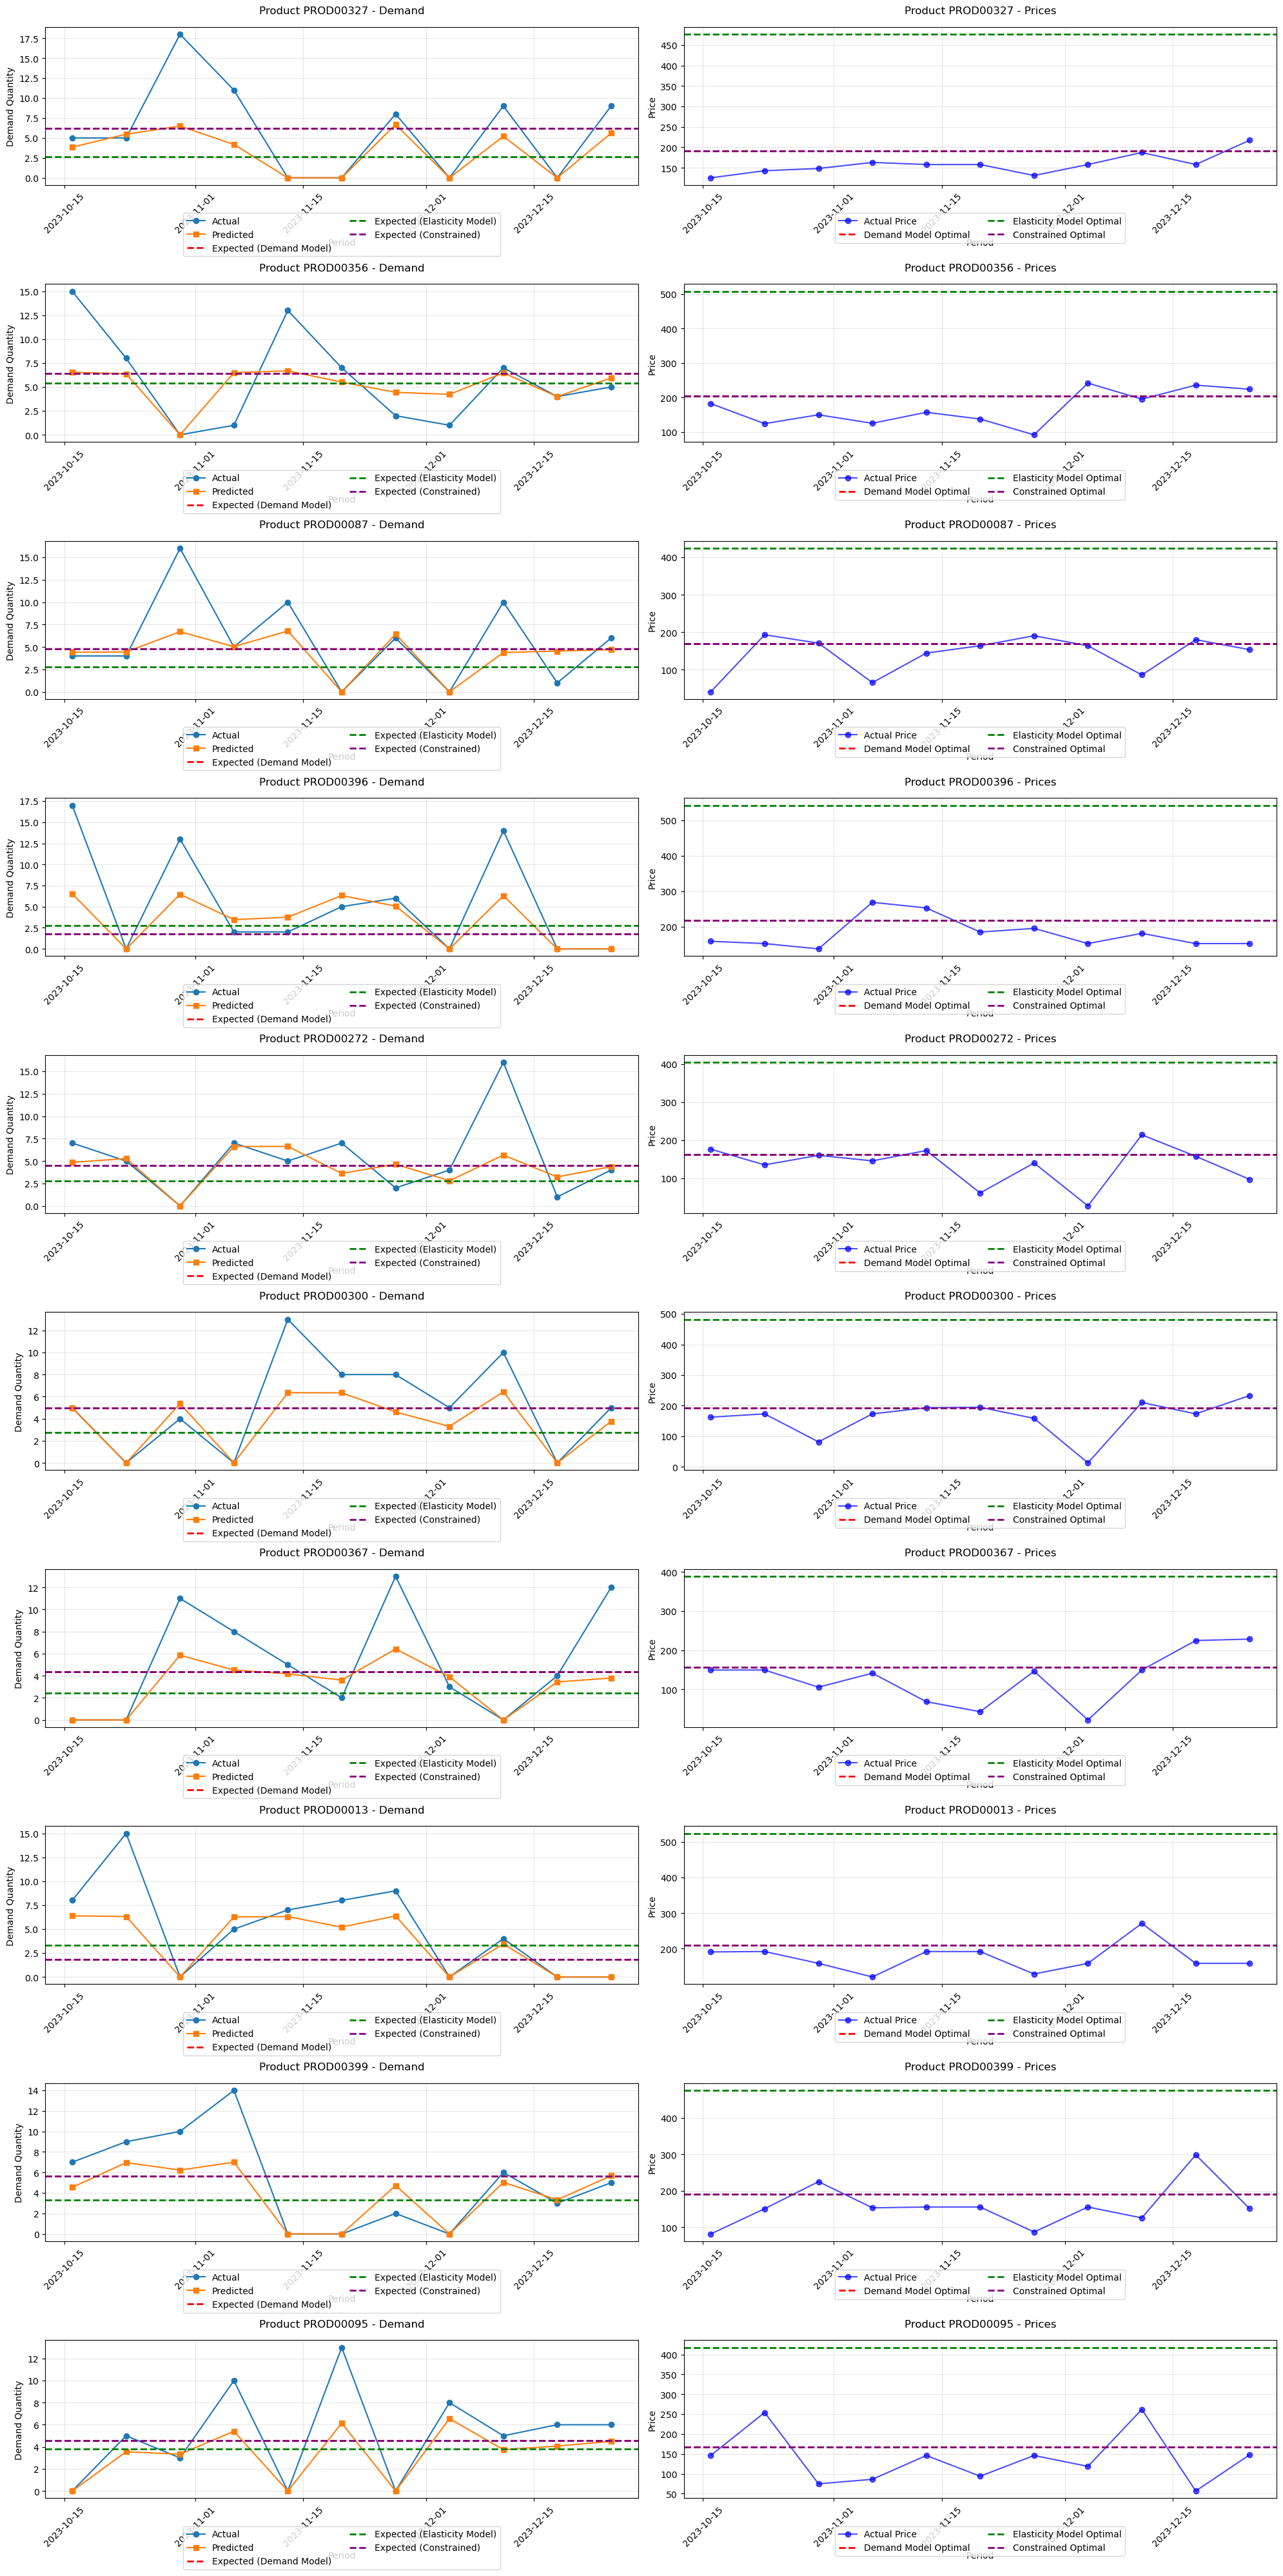

In [4]:

metrics_path = Path("metrics/backtest_metrics.json")
metrics_path.parent.mkdir(exist_ok=True)

results, metrics_store = backtest.run_backtest(
    products_df=products_df,
    transactions_df=transactions_df,
    inventory_df=inventory_df,
    test_months=3,
    features=features, 
    price_range_pct=0.2,
    price_steps=5,
    metrics_path=metrics_path
)


backtest.plot_results(results, top_n=10)


summary = backtest.get_summary_stats(results)
print("\nBacktest Summary Statistics:")
print(summary)


from src.models.metrics_store import get_latest_metrics, get_metrics_history

latest_demand_metrics = get_latest_metrics(metrics_store, "demand_forecaster", "regression")
latest_optimization_metrics = get_latest_metrics(metrics_store, "price_optimization", "regression")

print("\nDetailed Demand Forecasting Metrics:")
print(pd.Series(latest_demand_metrics))